In [167]:
import matplotlib.pyplot as plt
import numpy as np
# import cv2
import matplotlib.image as mpimg
import pydicom
import time
from skimage import io
from scipy.ndimage import gaussian_filter
import math

In [168]:
PATH = "src\\"

In [169]:
pi = np.pi

In [170]:
def read_file(direc, file, normalization):
    file = pydicom.read_file(direc+file)
    img = file.pixel_array
    if normalization == 1:
        data = img/(np.max(img)-np.min(img))  #normalization
    else:
        data = img
    return img, data

In [171]:
def initial_curve(center, width, img_size_row, img_size_col):
    initial_map = np.ones((img_size_row,img_size_col))*-2
    initial_map[center[0]-width:center[0]+width,center[1]-width:center[1]+width] *= -1
    return initial_map

In [172]:
def force(image,s_gradient, mean1, mean2):
    edge_constrain = 1/(1+s_gradient)
    f1 = (image-mean1)**2
    f2 = (image-mean2)**2
    eps = 1e-5
    return (1/2+f1*edge_constrain+eps)/((1+(f1+f2)*edge_constrain+2*eps)), (1/2+f2*edge_constrain+eps)/((1+(f1+f2)*edge_constrain+2*eps)) 

In [173]:
def delta(phi, eps):
    return 1/pi*(eps/(phi**2+eps**2)) #分析最大值

In [174]:
def gradient_square(img):
    return (np.gradient(img)[1])**2+(np.gradient(img)[0])**2

In [175]:
def K(phi):
    phi_x = np.gradient(phi)[1]
    phi_y = np.gradient(phi)[0]
    phi_xx = np.gradient(phi_x)[1]
    phi_xy = np.gradient(phi_x)[0]
    phi_yy = np.gradient(phi_y)[0]
    
    return (phi_xx * phi_y**2 + phi_yy * phi_x**2 - 2*phi_xy * phi_y*phi_x+1e-10)/((phi_x**2 + phi_y**2)**(3/2)+1e-10),  phi_xx+phi_yy

In [176]:
def show_contour(img, phi):
    plt.clf()
    plt.imshow(img,cmap = plt.cm.bone)
    plt.contour(phi,[0],colors='r',linewidths = 0.5) 
    plt.show()

In [177]:
def calculate_mean(img, phi, gradient):
    weight = 1/(1+gradient)
    c_1 = np.sum(img[(phi>0)]*(weight[(phi>0)]))/np.sum(weight[(phi>0)])
    c_2 = np.sum(img[(phi<0)]*(weight[(phi<0)]))/np.sum(weight[(phi<0)])

    return c_1, c_2

In [178]:
def evolution(data, phi, gamma1, gamma2, eta, gs_img, c1, c2, t_2, eps):
    f1, f2 = force(data, gs_img, c1, c2)
    
    curvature, _ = K(phi)
    
    phi_t = phi - delta(phi,eps)*(gamma1*f1-gamma2*f2-eta*curvature)
    
    _, laplacian = K(phi_t)
    phi_t = phi_t+t_2*laplacian
    c1_t, c2_t = calculate_mean(data, phi_t, gs_img)

    return c1_t, c2_t, phi_t #, functional(gamma1, gamma2, eta, f1, f2, phi_t, eps),f1, f2

In [179]:
def functional(gamma1, gamma2, eta, f1, f2, phi, eps):
     return np.sum(gamma1*f1*((phi>0).astype('int'))+gamma2*f2*((phi<0).astype('int'))+eta*delta(phi, eps)*gradient_square(phi)**0.5)
    

In [180]:
def main(img, data, center, width, eta, t_2, max_iteration, plot = 1):
    img_size_row, img_size_col= len(img), len(img[0])
    phi = (initial_curve(center, width, img_size_row, img_size_col))
    phi = phi/(np.max(phi)-np.min(phi))
    gs_img = gradient_square(data)

    c1 = np.mean(data[phi>0]) 
    c2 = np.mean(data[phi<0]) 
    start = time.time()
#     energy_array = []
    for t in range(0,max_iteration):
        
        c1_t, c2_t, phi_t = evolution(data, phi, 1, 1, eta, gs_img, c1, c2, t_2, 0.1)
        
#         energy_array.append(energy_t)
        if plot == 1:
            if  (t % 10 == 0):
                show_contour(img, phi)
                print(t)
        
        phi = phi_t        
        c1 = c1_t
        c2 = c2_t
    end = time.time()
    return phi, end-start

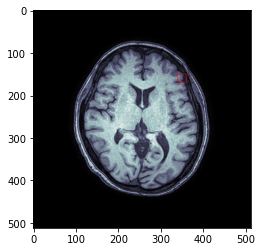

0


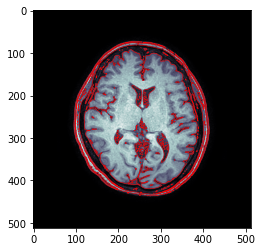

10


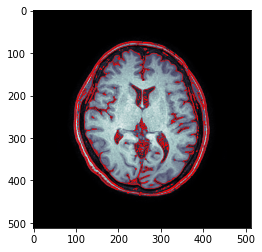

20


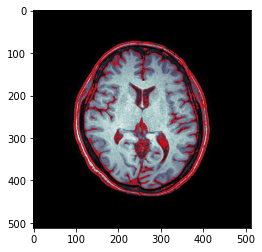

30


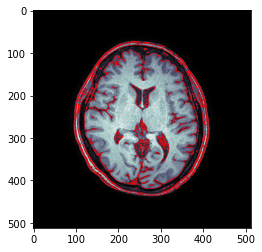

40


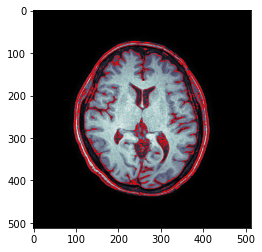

50


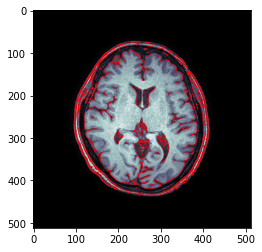

60


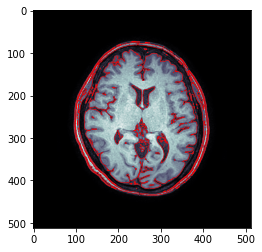

70


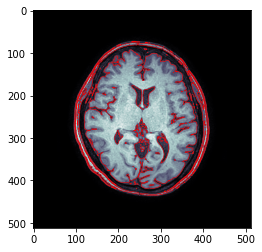

80


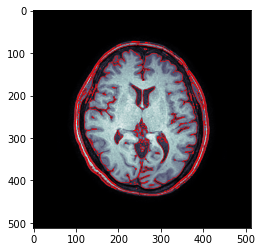

90
15.96884536743164


In [181]:
img, data = read_file(PATH, '80',1)
# ID = 'dragonfly'
# img = io.imread('testing image//'+ID+'.jpg')
ground_truth, duration = main(img, img, [160,350], 10, 1e-3,  0.01, 91,1)
print (duration)


In [ ]:
img

In [ ]:
from skimage import io

In [183]:
# file = pydicom.read_file(PATH+'80')
# plt.imshow(file.pixel_array, cmap = plt.cm.bone)
plt.imsave('image.png',img,cmap = plt.cm.bone)

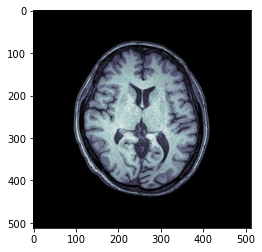

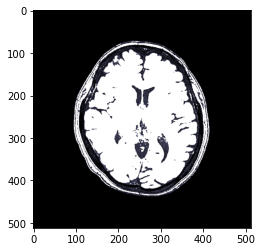

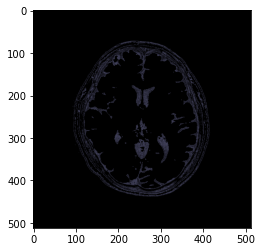

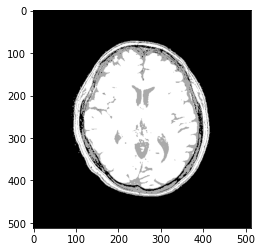

In [184]:
# %matplotlib qt
img_result = (io.imread('image.png', as_gray=False)[:,:,0:3])
fig1 = plt.figure()
img_result[img<20] = [0,0,0]
img_result[img>20] = img_result[img>20] 
# plt.imsave('90.bmp', img_result, dpi = 500)
# plt.clf()
plt.imshow(img_result)

# plt.show()
fig2 = plt.figure()
img_result[ground_truth>0] = [255,255,255]
img_result[ground_truth<0] = img_result[ground_truth<0]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave(ID+'.png', img_result, dpi = 500)
# plt.clf()

#     img_result[ground_truth<0] = [241,160,88]
fig3 = plt.figure()
img_result[ground_truth>0] = [0,0,0]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave('100_result_inside.bmp', img_result, dpi = 500)
# plt.clf()
fig4 = plt.figure()
img_result[ground_truth<0] = [170,170,170]
img_result[ground_truth>0] = [255,255,255]
img_result[img<20] = [0,0,0]
plt.imshow(img_result)
# plt.show()
# plt.imsave('100_binary.bmp', img_result, dpi = 500)
# plt.clf()

# Colored image

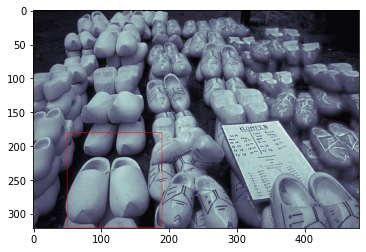

0


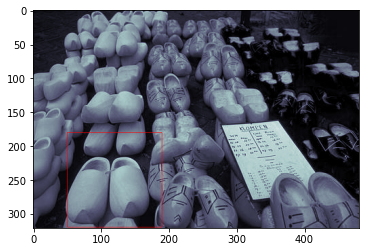

0


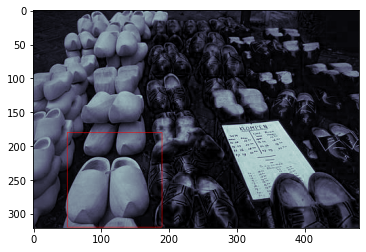

0


In [146]:
r = io.imread('testing image//shoes.jpg', as_gray=False)[:,:, 0]
g = io.imread('testing image//shoes.jpg', as_gray=False)[:,:, 1]
b = io.imread('testing image//shoes.jpg', as_gray=False)[:,:, 2]
r_gs, _ = main(r, r, [250,120], 70, 1e-3, 0.25, 5)
g_gs, _ = main(g, g, [250,120], 70, 1e-3, 0.25, 5)
b_gs, _ = main(b, b, [250,120], 70, 1e-3, 0.25, 5)
r_mean = np.mean(r[r_gs>0])
g_mean = np.mean(g[g_gs>0])
b_mean = np.mean(b[b_gs>0])


In [147]:
r.shape()

TypeError: 'tuple' object is not callable

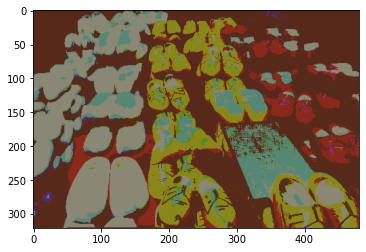

In [148]:
tmp_img =  np.copy(io.imread('testing image//shoes.jpg', as_gray=False))*0
tmp_img[(r_gs>0)&(g_gs>0)&(b_gs>0)] = [r_mean, g_mean, b_mean]

tmp_img[(r_gs>0)&(g_gs>0)&(b_gs<0)] = [r_mean, g_mean, np.mean(b[b_gs<0])]
tmp_img[(r_gs>0)&(g_gs<0)&(b_gs>0)] = [r_mean, np.mean(g[g_gs<0]), b_mean]
tmp_img[(r_gs<0)&(g_gs>0)&(b_gs>0)] = [np.mean(r[r_gs<0]), g_mean, b_mean]
tmp_img[(r_gs<0)&(g_gs<0)&(b_gs>0)] = [np.mean(r[r_gs<0]), np.mean(g[g_gs<0]), b_mean]
tmp_img[(r_gs>0)&(g_gs<0)&(b_gs<0)] = [r_mean, np.mean(g[g_gs<0]), np.mean(b[b_gs<0])]
tmp_img[(r_gs<0)&(g_gs>0)&(b_gs<0)] = [np.mean(r[r_gs<0]), g_mean , np.mean(b[b_gs<0])]
tmp_img[(r_gs<0)&(g_gs<0)&(b_gs<0)] = [np.mean(r[r_gs<0]), np.mean(g[g_gs<0]) , np.mean(b[b_gs<0])]
plt.imshow(tmp_img)
plt.imsave(ID+'.png', img_result, dpi = 500)
# plt.imsave('all.png', tmp_img, dpi = 500)
plt.show()
# tmp_img[]

In [104]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [106]:
(img[:,:,0])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [105]:
mask = (tmp_img[:,:,0]>200)&(tmp_img[:,:,1]>200)
r = r*(mask).astype(int)
g = g*(mask).astype(int)
b = b*(mask).astype(int)
plt.imshow([r_shoe, g_shoe, b_shoe])
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

# Noise experience

In [ ]:
plt.imshow(io.imread('testing image//lizard.jpg', as_gray=True)*(g_gs>0).astype(int), cmap = plt.cm.bone)

In [150]:
image_set = ['80', '90', '100', '105']
center_parameter_set = [[250,290], [250,200], [200, 200], [200, 200]]
radii_set = [20,20,20,20]
eta_set = [1e-2, 1e-4, 1e-2, 1e-3]
t_2_set = [0.1, 0.1, 0.15, 0.15]
iteration_set = [5, 6, 6, 5]


In [151]:
def dice_score(ground_truth, result):
    a = np.sum(((ground_truth>0)&(result>0)).astype(int))
    b = np.sum(((ground_truth>0)).astype(int))
    c = np.sum(((result>0)).astype(int))
    d = np.sum(((ground_truth>0)|(result>0)).astype(int))
    return a/d

In [152]:
def SSIMnp(y_true , y_pred):
    u_true = np.mean(y_true)
    u_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    std_true = np.sqrt(var_true)
    std_pred = np.sqrt(var_pred)
    c1 = np.square(0.01*7)
    c2 = np.square(0.03*7)
    ssim = (2 * u_true * u_pred + c1) * (2 * std_pred * std_true + c2)
    denom = (u_true ** 2 + u_pred ** 2 + c1) * (var_pred + var_true + c2)
    return ssim / denom

In [185]:
def psnr(img1, img2):
    mse = np.mean(((img1-img2)**2).flatten())
#     print(mse)
    if mse == 0:
        return 100
    PIXEL_MAX = np.max(img1)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [154]:
def PepperandSalt(src,percetage):
    NoiseImg = np.copy(src)
    max_pixel = np.max(src)
    NoiseNum=int(percetage/100*src.shape[0]*src.shape[1])
    N = src.shape[0]
    M = src.shape[1]
    for i in range(NoiseNum):
        randX=np.random.randint(0,511)
        randY=np.random.randint(0,511)
        if np.random.random() <= 0.5:
            NoiseImg[randX,randY]=0
        else:
            NoiseImg[randX,randY]=max_pixel
#     NoiseImg[img<20] = 0        
    return NoiseImg


In [155]:
def convoultion(src, s):
    return gaussian_filter(src, sigma=s)
# psnr(img, PepperandSalt(img, 5))

In [187]:
gaussian_add_variance_set = [i for i in range(2,50,2)]
gaussian_convolution_variance_set = [0.7+0.3*i for i in range(0,50,2)]
pepper_percentage_set = [0.5+i*0.3 for i in range(50)]
noise_type = [gaussian_add_variance_set, gaussian_convolution_variance_set, pepper_percentage_set]

In [188]:
result = []
for noise_idx in range(len(noise_type)):
    result_noise = []
    for image_id in range(len(image_set)):
        img = pydicom.read_file(PATH+image_set[image_id]).pixel_array
        
        for test_para in noise_type[noise_idx]:
            if noise_idx == 0:
                noise_image = np.copy(img)+np.random.normal(0, test_para, (512,512))
            elif noise_idx == 1:
                noise_image = convoultion(img, test_para)
            elif noise_idx == 2:
                noise_image = PepperandSalt(img, test_para)
           
            noise_image[img<20] = 0
            
            ground_truth, _ = main(img, img, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)

            noise_result, _ = main(noise_image, noise_image, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)
            result_noise.append(np.array([psnr(img,noise_image), dice_score(ground_truth, noise_result)]))
    result.append(np.array(result_noise))     

In [189]:
gauss_add = result[0]
gauss_convol = result[1]
pepper = result[2]

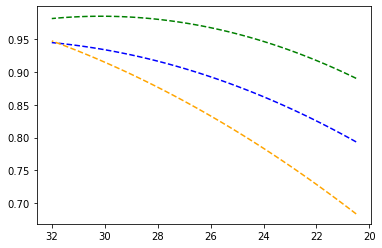

In [244]:

plt.gca().invert_xaxis()
plt.show()

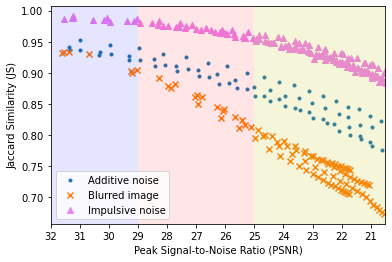

In [329]:
plt.scatter(gauss_add[:,0][gauss_add[:,0]<32],gauss_add[:,1][gauss_add[:,0]<32], marker='.', label = 'Additive noise')
plt.scatter(gauss_convol[:,0][gauss_convol[:,0]<32],gauss_convol[:,1][gauss_convol[:,0]<32],marker='x', label = 'Blurred image')
plt.scatter(pepper[:,0][pepper[:,0]<32],pepper[:,1][pepper[:,0]<32],marker='^',  label = 'Impulsive noise', c = 'violet')
plt.axvspan(29, 32, facecolor='b', alpha=0.1)
plt.axvspan(25, 29, facecolor='r', alpha=0.1)
plt.axvspan(20.5, 25, facecolor='y', alpha=0.15)
plt.xlim(20.5,32)
# additive = np.poly1d(np.polyfit(gauss_add[:,0][gauss_add[:,0]<32], gauss_add[:,1][gauss_add[:,0]<32], 2))
# blurred = np.poly1d(np.polyfit(gauss_convol[:,0][gauss_convol[:,0]<32],gauss_convol[:,1][gauss_convol[:,0]<32], 2))
# impulsive = np.poly1d(np.polyfit(pepper[:,0][pepper[:,0]<32],pepper[:,1][pepper[:,0]<32], 2))
# myline = np.linspace(20.5, 32, 100)
# plt.plot(myline, additive(myline), '--', c = 'deeppink')
# plt.plot(myline, blurred(myline), '--', c = 'navy')
# plt.plot(myline, impulsive(myline), '--', c = 'black')
plt.legend()
plt.xticks( np.linspace(21,32,12))
plt.xlabel('Peak Signal-to-Noise Ratio (PSNR)')
plt.ylabel('Jaccard Similarity (JS)')
plt.gca().invert_xaxis()
plt.savefig('Dice_score_all_noise_scatter.png', dpi = 1000)

In [324]:
np.linspace(21,32,12)

array([21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.])

In [ ]:
thresholds = [30,27,25, 23, 20]

In [ ]:
gauss_add_gps = [gauss_add[(gauss_add[:,0]>=thresholds[0])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[0])&(gauss_add[:,0]>=thresholds[1])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[1])&(gauss_add[:,0]>=thresholds[2])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[2])&(gauss_add[:,0]>=thresholds[3])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[3])&(gauss_add[:,0]>=thresholds[4])][:,1],
 gauss_add[(gauss_add[:,0]<thresholds[4])][:,1]]

gauss_convol_gps = [gauss_convol[(gauss_convol[:,0]>=thresholds[0])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[0])&(gauss_convol[:,0]>=thresholds[1])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[1])&(gauss_convol[:,0]>=thresholds[2])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[2])&(gauss_convol[:,0]>=thresholds[3])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[3])&(gauss_convol[:,0]>=thresholds[4])][:,1],
 gauss_convol[(gauss_convol[:,0]<thresholds[4])][:,1]]

pepper_gps = [pepper[(pepper[:,0]>=thresholds[0])][:,1],
 pepper[(pepper[:,0]<thresholds[0])&(pepper[:,0]>=thresholds[1])][:,1],
 pepper[(pepper[:,0]<thresholds[1])&(pepper[:,0]>=thresholds[2])][:,1],
 pepper[(pepper[:,0]<thresholds[2])&(pepper[:,0]>=thresholds[3])][:,1],
 pepper[(pepper[:,0]<thresholds[3])&(pepper[:,0]>=thresholds[4])][:,1],
 pepper[(pepper[:,0]<thresholds[4])][:,1]]

In [ ]:
gauss_convol_gps

In [ ]:
plt.figure()
bp = plt.boxplot(gauss_add_gps[:-1], labels = ['over 30', '30~28', '28~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.65,1)
plt.savefig('gaussian_noise.png', dpi = 500)

In [ ]:
gauss_convol_gps

In [ ]:
plt.figure()
bp = plt.boxplot(gauss_convol_gps[:-1], labels = ['over 30', '30~28', '28~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.645,1.01)
plt.savefig('gaussian_convol_noise.png', dpi = 500)

In [ ]:
pepper_gps

In [ ]:
plt.figure()
bp = plt.boxplot([pepper_gps[0],pepper_gps[1], pepper_gps[2], np.append(pepper_gps[3], pepper_gps[4])], labels = ['over 30', '30~25', '25~23', 'less than 23'])
plt.xlabel('PSNR value')
plt.ylabel('Dice score')
plt.ylim(0.645,1.01)
# plt.savefig('gaussian_convol_noise.png', dpi = 500)

In [ ]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [ ]:
plt.boxplot(gauss_convol_gps)

In [ ]:
bp1 = plt.boxplot(gauss_add_gps, positions = [0,4,8,12,16])
bp2 = plt.boxplot(gauss_convol_gps, positions = [1,5,9,13,17])
bp3 = plt.boxplot(pepper_gps, positions = [3,6,10,14,18])
set_box_color(bp1, 'red')
set_box_color(bp2, 'blue')
set_box_color(bp3, 'green')

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(np.arange(len(gauss_add_gps)), [np.mean(i) for i in np.array(gauss_add_gps, dtype='object')], 'ob-' , mfc = 'r', label = 'Additive noise')
plt.plot(np.arange(len(gauss_convol_gps[:-1])), [np.mean(i) for i in np.array(gauss_convol_gps[:-1], dtype='object')], '^g-' , mfc = 'r', label = 'Blurred image')
plt.plot(np.arange(len(pepper_gps)), [np.mean(i) for i in np.array(pepper_gps, dtype='object')], 'sk-' , mfc = 'r', label = 'Impulse noise')
plt.xlabel('PSNR value')
plt.ylabel('Jaccard similarity')
plt.xticks([0,1,2,3,4,5], ['over 30','30~27','27-25', '25-23', '23-20', 'less than 20'])
plt.legend()
plt.savefig('Dice_score_all_noise.png', dpi = 1000)
plt.show()

In [ ]:
plt.figure(figsize = (8,5))
plt.plot(np.arange(len(pepper_gps)), [np.mean(i) for i in np.array(pepper_gps, dtype='object')], 'sk-' , mfc = 'r', label = 'Impulse noise')
plt.xlabel('PSNR value')
plt.ylabel('Jaccard similarity')
plt.xticks([0,1,2,3,4,5], ['over 30','30~27','27-25', '25-23', '23-20', 'less than 20'])
plt.legend()
plt.savefig('impulse_Dice_score.png', dpi = 1000)
plt.show()

In [ ]:
img = pydicom.read_file(PATH+image_set[0]).pixel_array
img_add = np.copy(img)+np.random.normal(0, 40, (512,512))
img_add[img<20] = 0
img_conv = convoultion(np.copy(img), 3)
img_conv[img<20] = 0
img_pepper = PepperandSalt(np.copy(img), 10)
img_pepper[img<20] = 0

In [ ]:
plt.imsave('additive_noise_'+str(psnr(img, img_add))+'.png',img_add, cmap = plt.cm.bone, dpi = 500)
plt.imshow(img_add, cmap =  plt.cm.bone)
plt.show()
plt.imsave('conolution_noise_'+str(psnr(img, img_conv))+'.png',img_conv, cmap = plt.cm.bone, dpi = 500)
plt.imshow(img_conv, cmap = plt.cm.bone)
plt.show()
plt.imsave('pepper_noise_'+str(psnr(img, img_pepper))+'.png',img_pepper, cmap = plt.cm.bone, dpi = 500)
plt.imshow(img_pepper, cmap = plt.cm.bone)
plt.show()

In [ ]:
image_id = 2
para_set = [1]
for i in para_set:
    img = pydicom.read_file(PATH+image_set[image_id]).pixel_array
    plt.imsave('image.png', img, cmap = plt.cm.bone, dpi = 500)
#     img_add_1 = np.copy(img)+np.random.normal(0, i, (512,512))
#     img_add_1 = convoultion(img, i)
    img_add_1 = PepperandSalt(img, i)
    img_add_1[img<50] = 0
    print('psnr =', psnr(img, img_add_1))
#     plt.imsave('additive_noise'+str(int(psnr(img, img_add_1)))+'.png',img_add_1, cmap = plt.cm.bone, dpi = 500)
    gs_1, _ = main(img_add_1,img_add_1, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)
    gs, _ = main(img,img, center_parameter_set[image_id],
                                   radii_set[image_id],
                                   eta_set[image_id],
                                   t_2_set[image_id], iteration_set[image_id], 0)
    
    fig2 = plt.figure()
    img_result = (io.imread('image.png', as_gray=False)[:,:,0:3])
    img_result[gs<0] = [241,160,88]
    img_result[gs>0] = [0,0,0]
    img_result[img<50] = [0,0,0]
    
    plt.imshow(img_result)
    plt.show()
    print(dice_score(gs, gs_1))
#     plt.imsave('result_additive_noise_'+str(int(psnr(img, img_add_1)))+'.png',img_result, cmap = plt.cm.bone, dpi = 500)
    # plt.show()

In [ ]:
img = pydicom.read_file(PATH+image_set[0]).pixel_array

img_add_2 = np.copy(img)+np.random.normal(0, 30, (512,512))
img_add_2[img<20] = 0
plt.imsave('additive_noise_'+str(psnr(img, img_add_2))+'.png',img_add_2, cmap = plt.cm.bone, dpi = 500)
img_add_3 = np.copy(img)+np.random.normal(0, 40, (512,512))
img_add_3[img<20] = 0
plt.imsave('additive_noise_'+str(psnr(img, img_add_3))+'.png',img_add_3, cmap = plt.cm.bone, dpi = 500)
# psnr(img, img_add_1)
# psnr(img, img_add_2)
# psnr(img, img_add_3)


In [ ]:
s = np.random.normal(0, 30, (512,512))
gaussian_noise = np.copy(img)+s.astype(int)

In [ ]:
gaussian_noise[img<20] = 0

In [ ]:
plt.imshow(gaussian_noise, cmap = plt.cm.bone)
plt.show()

In [ ]:
d=psnr(img,gaussian_noise)
print(d)

In [ ]:
plt.imsave('Gaussian_noise_SNR_'+str(round(d,2))+'.png', gaussian_noise,cmap = plt.cm.bone, dpi = 150)

In [ ]:
test, _ = main(gaussian_noise,  gaussian_noise, [250,300], 10, 5,1)

In [ ]:
plt.clf()
plt.imshow(img*((test<0).astype(int)), cmap = plt.cm.bone)
# plt.imsave( 'gaussian_noise_target.png',gaussian_noise*((test<0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()
plt.clf()
plt.imshow(img*((ground_truth<0).astype(int)), cmap = plt.cm.bone)
# plt.imsave( 'IM120_back.png',img*((ground_truth>0).astype(int)),cmap = plt.cm.bone,  dpi = 500)
plt.show()

In [ ]:
dice_score(ground_truth, test)

In [ ]:
SSIMnp(img*((ground_truth<0).astype(int)), gaussian_noise*((test<0).astype(int)))

In [ ]:
from skimage import io
noisy_img = io.imread('SNR_'+str(round(d,2))+'.png', as_gray=False)[:,:,0:3]
plt.imshow(noisy_img)

In [ ]:
noisy_img[test<0]

In [ ]:
noisy_img[test>0] = [241,160,88]
noisy_img[pepper<350] = [0,0,0]
plt.imshow(noisy_img)

plt.imsave('SNR_'+str(round(d,2))+'result.png', noisy_img)

In [ ]:
plt.imsave('IM120.png', img, cmap = plt.cm.bone, dpi = 150)

In [ ]:
plt.clf()
clean_img = io.imread('IM120.png', as_gray=False)[:,:,0:3]
plt.imshow(clean_img)
clean_img[ground_truth>0] = [241,160,88]
clean_img[img<350] = [0,0,0]
plt.imshow(clean_img)

# plt.imsave('clean_with_SNR_'+str(round(d,2))+'result.png', clean_img)

In [ ]:
plt.plot(np.linspace(0,1,4),[0,0,0,0], 'r-', marker = 'x')
plt.plot(np.linspace(0,1,4),[1,1,1,1], 'b-', marker = 'o')
plt.plot(np.linspace(0,2/3,3), [0,0.5,1])
plt.ylabel('time')
plt.xlabel('grid')
plt.xticks(np.linspace(0,1,4),['$x_{i-1}$', '$x_i$', '$x_i$', '$x_i$'])
plt.show()

In [ ]:
np.linspace(0,1,4)
np.zeros(5)